In [1]:
import warnings
import polars as pl
from datetime import datetime

from tqdm.auto import tqdm

import requests
import json

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

# https://stackoverflow.com/q/70234041/15937542
# Need to set this
pl.enable_string_cache(True)

In [2]:
folder_path="datasets/13_gh_proximities/"

### Istanbul Landmarks (Tourist spots, Historical Monuments, Bridges, etc.)

In [3]:
gh_landmarks = (   
    # Read fine
    pl.read_csv(folder_path + "gh_nearby_landmarks.csv")
    .filter(pl.col('type').ne('landmark'))

    # Grouping by GEOHASH and taking number of unique nearby landmarks
    .groupby('name').agg(pl.col('nearest').n_unique())

    # downcasting datatypes
    .with_columns(pl.col('name').cast(pl.Categorical),
                  pl.col('nearest').cast(pl.UInt8))

    # rename columns
    .rename({"name" : "GEOHASH", "nearest" : "NEARBY_LANDMARKS_CNT"})
)

gh_landmarks.head()

GEOHASH,NEARBY_LANDMARKS_CNT
cat,u8
"""sxk9kx""",2
"""sxk97t""",3
"""sxk9d2""",2
"""sxk9v2""",1
"""sxk9db""",1


### Football Matches

In [4]:
gh_stadiums = (
    pl.read_csv(folder_path + "gh_nearby_stadiums.csv")
    .filter(pl.col('type').eq('geohash'))
    .select(['name', 'nearest'])
    .rename({"nearest" : "stadium"})
)

gh_stadiums.head()

name,stadium
str,str
"""sxk3zw""","""BAŞAKŞEHİR FAT…"
"""sxk3zt""","""BAŞAKŞEHİR FAT…"
"""sxk3zx""","""BAŞAKŞEHİR FAT…"
"""sxk97m""","""RECEP TAYYİP E…"
"""sxk97q""","""RECEP TAYYİP E…"


In [5]:
gh_football_match_info = (   
    
    # Read CSV containing date and times of football matchrs
    pl.read_csv("datasets/05_tr_football_matches/tr_ist_2019_2023_football_matches.csv")
    .select(['date', 'stadium'])

    # Convert column to datetime and round time to nearest hour.
    # For eg, YYYY-MM-DD 20:15:00 -> YYYY-MM-DD 20:00:00
    .with_columns(pl.col('date')
                  .str.to_datetime(time_unit='ns')
                  .dt.round("-1h"))

    # Join with gh_stadiums to get nearby GEOHASH for each stadium
    .join(gh_stadiums, on='stadium')
    .drop('stadium')

    # Creating a column with constant value 1. 
    # This will converted to a boolean column.
    # 1 indicates True that a match was held on this datetime near this GEOHASH
    .with_columns(pl.lit(1).alias('IS_FOOTBALL_MATCH'),
                  pl.col('name').cast(pl.Categorical))
    .rename({'date' : 'DATE_TIME', 'name' : 'GEOHASH'})
)

gh_football_match_info.head()

DATE_TIME,GEOHASH,IS_FOOTBALL_MATCH
datetime[ns],cat,i32
2019-08-07 21:00:00,"""sxk3zw""",1
2019-08-07 21:00:00,"""sxk3zt""",1
2019-08-07 21:00:00,"""sxk3zx""",1
2019-08-18 22:00:00,"""sxk97m""",1
2019-08-18 22:00:00,"""sxk97q""",1


### ISPARK Parking

In [6]:
gh_ispark = (
    pl.read_csv(folder_path + "gh_nearby_isparks.csv")
    .filter(pl.col('type').eq('geohash'))
    .select(['name', 'nearest'])
    .rename({'name' : 'GEOHASH', 'nearest' : 'parkName'})
)

gh_ispark.head()

GEOHASH,parkName
str,str
"""sxk96u""","""1293 Yavuz Sel…"
"""sxk96g""","""1293 Yavuz Sel…"
"""sxk96v""","""1293 Yavuz Sel…"
"""sxk96f""","""1293 Yavuz Sel…"
"""sxk93x""","""15 Temmuz Demo…"


In [7]:
gh_ispark_capacity = (

    # gh_ispark will be joined with this dataset to get the nearby parking capacity
    pl.read_csv("datasets/11_tr_ist_ispark_parking/tr_ist_ispark_list.csv")
    .select(['parkName', 'capacity'])
    .join(gh_ispark, on='parkName', how='inner')

    # since some geohash are closer to multiple ISPARK parking spots,
    # the total sum of parking capacity will be taken for each GEOHASH
    .groupby('GEOHASH').agg(pl.col('capacity').sum())

    .with_columns(pl.col('GEOHASH').cast(pl.Categorical),
                  pl.col('capacity').cast(pl.UInt16))
    .rename({'capacity' : 'NEARBY_PARKING_CAPACITY'})
)

gh_ispark_capacity.head()

GEOHASH,NEARBY_PARKING_CAPACITY
cat,u16
"""sxk90y""",120
"""sxk981""",463
"""sxk96c""",1877
"""sxk90n""",424
"""sxk9ns""",130


### Taxi Stands

In [8]:
gh_taxi_stands = (
    pl.read_csv(folder_path + "gh_nearby_taxi_stands.csv")
    .filter(pl.col('type').eq('geohash'))
    .select(['name', 'nearest'])

    # grouping by GEOHASH and taking unique count of all near by taxi stands
    .groupby('name').agg(pl.col('nearest').n_unique())
    
    .rename({'name' : 'GEOHASH', 'nearest' : 'NEARBY_TAXI_STND_CNT'})
    .with_columns(pl.col('GEOHASH').cast(pl.Categorical),
                  pl.col('NEARBY_TAXI_STND_CNT').cast(pl.UInt8))
)

gh_taxi_stands.head()

GEOHASH,NEARBY_TAXI_STND_CNT
cat,u8
"""sxk9ks""",5
"""sxk9np""",2
"""sxk9rv""",1
"""sxk8yv""",2
"""sxk3zd""",1


### Minibus stops

In [9]:
gh_minibus_stops = (
    pl.read_csv(folder_path + "gh_nearby_minibus_stops.csv")
    .filter(pl.col('type').eq('geohash'))
    .select(['name', 'nearest'])

    # grouping by GEOHASH and taking unique count of all near by minibus stops
    .groupby('name').agg(pl.col('nearest').n_unique())
    
    .rename({'name' : 'GEOHASH', 'nearest' : 'NEARBY_MINIBUS_STOPS_CNT'})
    .with_columns(pl.col('GEOHASH').cast(pl.Categorical),
                  pl.col('NEARBY_MINIBUS_STOPS_CNT').cast(pl.UInt8))
)

gh_minibus_stops.head()

GEOHASH,NEARBY_MINIBUS_STOPS_CNT
cat,u8
"""sxk8wz""",9
"""sxk9nd""",1
"""sxk984""",1
"""sxk9r3""",1
"""sxk9jr""",2


### Ferry (Iskelesi)

In [10]:
gh_ferries = (
    pl.read_csv(folder_path + "gh_nearby_ferries.csv")
    .filter(pl.col('type').eq('geohash'))
    .select(['name', 'nearest'])

    # # grouping by GEOHASH and taking unique count of all near by Ferries
    .groupby('name').agg(pl.col('nearest').n_unique())
    
    .rename({'name' : 'GEOHASH', 'nearest' : 'NEARBY_FERRIES_CNT'})
    .with_columns(pl.col('GEOHASH').cast(pl.Categorical),
                  pl.col('NEARBY_FERRIES_CNT').cast(pl.UInt8))
)

gh_ferries.head()

GEOHASH,NEARBY_FERRIES_CNT
cat,u8
"""sxk9kp""",1
"""sxk96w""",4
"""sxk9d3""",1
"""sxk8yf""",1
"""sxk9hw""",1


### Metro Stations

In [11]:
gh_metro_stn = (
    pl.read_csv(folder_path + "gh_nearby_metro_stns.csv")
    .filter(pl.col('type').eq('geohash'))
    .select(['name', 'nearest'])

    # grouping by GEOHASH and taking unique count of near by Metro Stations
    # Note: Some metro stations have multiple exit points.
    .groupby('name').agg(pl.col('nearest').n_unique())

    .rename({'name' : 'GEOHASH', 'nearest' : 'NEARBY_METRO_STNS_CNT'})
    .with_columns(pl.col('GEOHASH').cast(pl.Categorical),
                  pl.col('NEARBY_METRO_STNS_CNT').cast(pl.UInt8))
)

gh_metro_stn.head()

GEOHASH,NEARBY_METRO_STNS_CNT
cat,u8
"""sxk9dd""",2
"""sxk9pm""",1
"""sxk980""",3
"""sxk9jp""",1
"""sxk9jr""",2


### Bus Stops

In [12]:
gh_bus_stops = (
    pl.read_csv(folder_path + "gh_nearby_bus_stns.csv")
    .filter(pl.col('type').eq('geohash'))
    .select(['name', 'nearest'])
    .with_columns(pl.col('nearest').cast(pl.Utf8))

    # grouping by GEOHASH and taking unique count of near by Metro Stations
    .groupby('name').agg(pl.col('nearest').n_unique())

    .rename({'name' : 'GEOHASH', 'nearest' : 'NEARBY_BUS_STOP_CNT'})
    .with_columns(pl.col('GEOHASH').cast(pl.Categorical),
                  pl.col('NEARBY_BUS_STOP_CNT').cast(pl.UInt8))
)

gh_bus_stops.head()

GEOHASH,NEARBY_BUS_STOP_CNT
cat,u8
"""sxk3qe""",19
"""sxk9bp""",15
"""sxkc33""",32
"""sx7cxs""",7
"""sxk6x7""",2


### Weather Data - Data Cleaning
    As there are issues with data called from Python meteostat package, another API will be used to get weather data.

In [13]:
cluster_coords = (
    pl.read_csv("datasets/15_gh_info/geohash_traffic_density_pt_15clusters.csv", 
                columns=['label', 'centroid_lat', 'centroid_lon'])
    .unique()
    .sort('label')
)

cluster_coords

label,centroid_lat,centroid_lon
i64,f64,f64
0,40.928072,29.314222
1,41.18631,28.834299
2,41.101532,28.218842
3,41.06027,28.953637
4,41.082676,28.476842
5,41.01368,29.091269
6,41.03425,28.830132
7,41.241228,28.035212
8,41.036944,28.668998


In [14]:
def req_weather_api(cluster: int) -> pl.DataFrame:
    """
    Function to request weather data from the API.
    Output is a polars Data Frame.
    """

    lat = cluster_coords.filter(pl.col('label').eq(cluster))['centroid_lat'][0]
    lon = cluster_coords.filter(pl.col('label').eq(cluster))['centroid_lon'][0]

    url=f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}&start_date=2020-01-01&end_date=2023-04-30"\
        f"&hourly=temperature_2m,relativehumidity_2m,precipitation,rain,snowfall,weathercode,windspeed_100m"\
         "&timezone=auto&min=2023-05-28&max=2023-06-11"
    
    r = requests.get(url)

    if r.status_code==200:
        
        json_obj = json.loads(r.text)

        df = (
            pl.DataFrame(json_obj['hourly'])
            .with_columns(pl.col('time').str.to_datetime(time_unit='ns'))
            .with_columns(pl.lit(cluster).alias('CLUSTER').cast(pl.UInt8))
        )

        return df

In [15]:
# These codes will be commented now as data has already been extracted.
# When re running the notebook, the data will be read from the saved CSV file

# wthr_df = pl.concat((req_weather_api(cluster=i) for i in tqdm(range(15))))
# wthr_df.write_csv("datasets/14_weather/tr_ist_weather_data_20200101_20230430.csv")

In [16]:
wthr_df = pl.read_csv("datasets/14_weather/tr_ist_weather_data_20200101_20230430.csv")
wthr_df.head()

time,temperature_2m,relativehumidity_2m,precipitation,rain,snowfall,weathercode,windspeed_100m,CLUSTER
str,f64,i64,f64,f64,f64,i64,f64,i64
"""2020-01-01T00:…",6.1,84,0.0,0.0,0.0,2,15.6,0
"""2020-01-01T01:…",6.3,82,0.0,0.0,0.0,2,17.4,0
"""2020-01-01T02:…",6.4,81,0.0,0.0,0.0,1,20.3,0
"""2020-01-01T03:…",6.3,80,0.0,0.0,0.0,2,21.2,0
"""2020-01-01T04:…",6.2,79,0.0,0.0,0.0,2,21.6,0


In [17]:
wthr_df.null_count()

time,temperature_2m,relativehumidity_2m,precipitation,rain,snowfall,weathercode,windspeed_100m,CLUSTER
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0


In [18]:
def plot_wthr_ts(col):
    (
        wthr_df.select(['time', 'CLUSTER', col])
        .pivot(index='time', columns='CLUSTER', values=col)
        .with_columns(pl.col('time').str.to_datetime(time_unit='ns'))
        .to_pandas()
        .set_index('time')
        .plot(subplots=True, figsize=(10, 25))
    )

    plt.suptitle(col, y=0.9)

    plt.show();

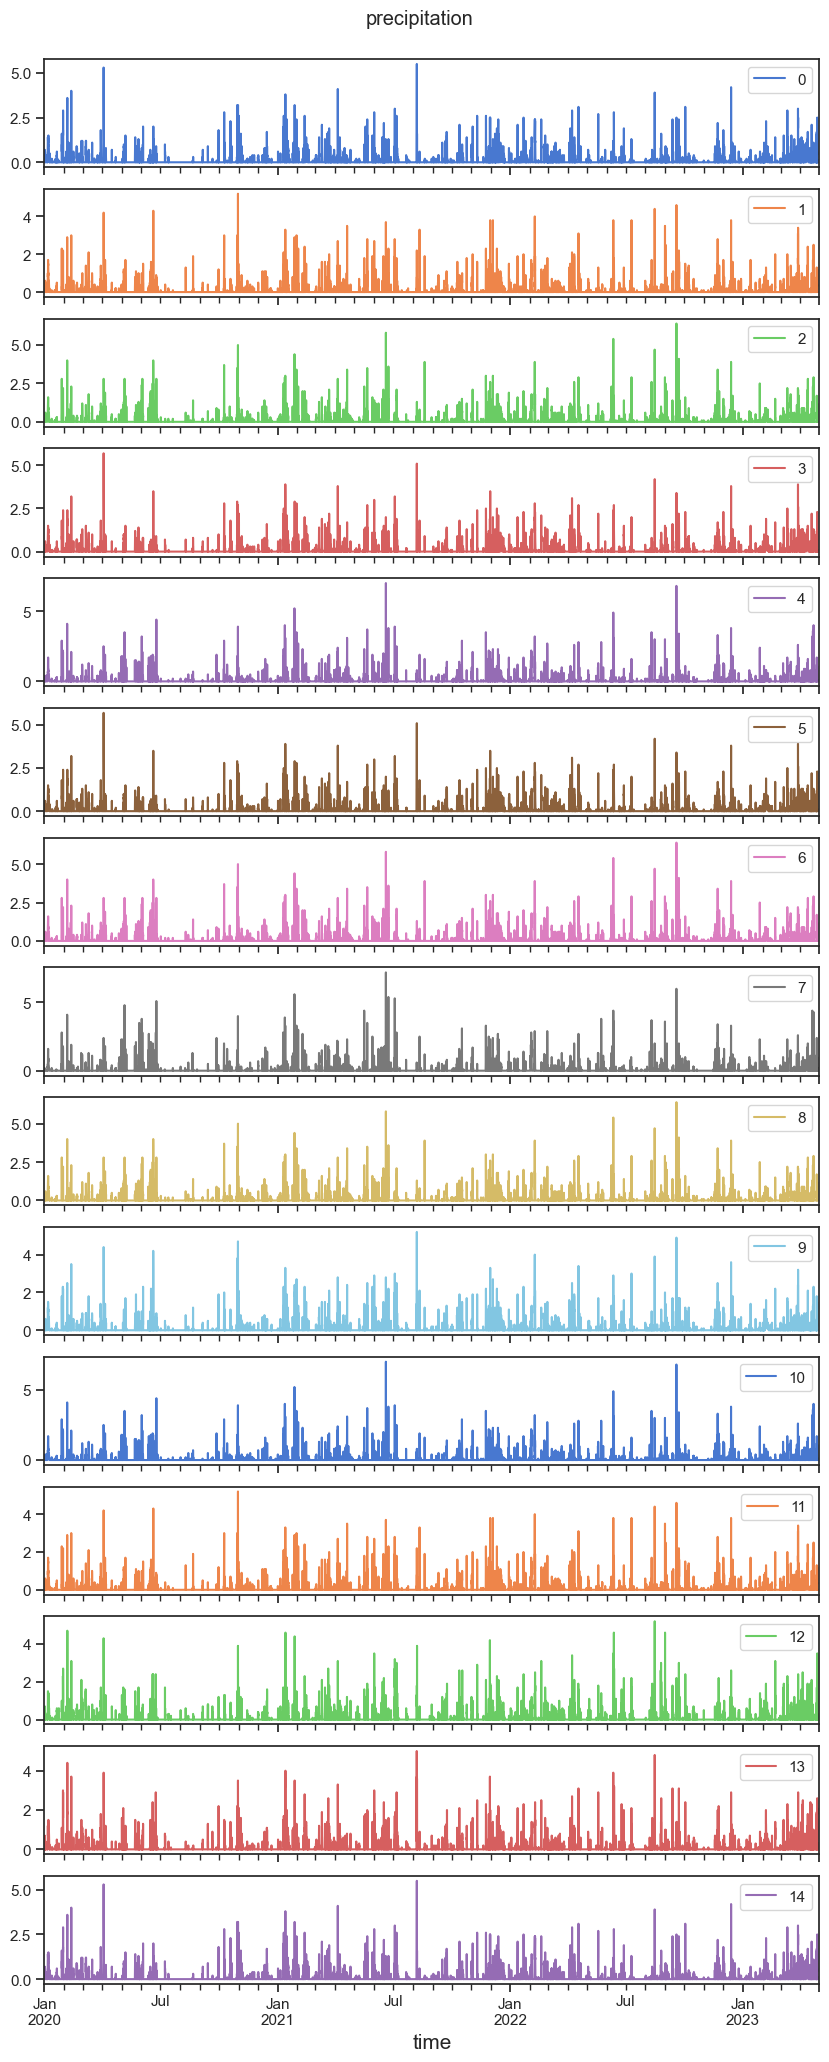

In [19]:
plot_wthr_ts('precipitation')

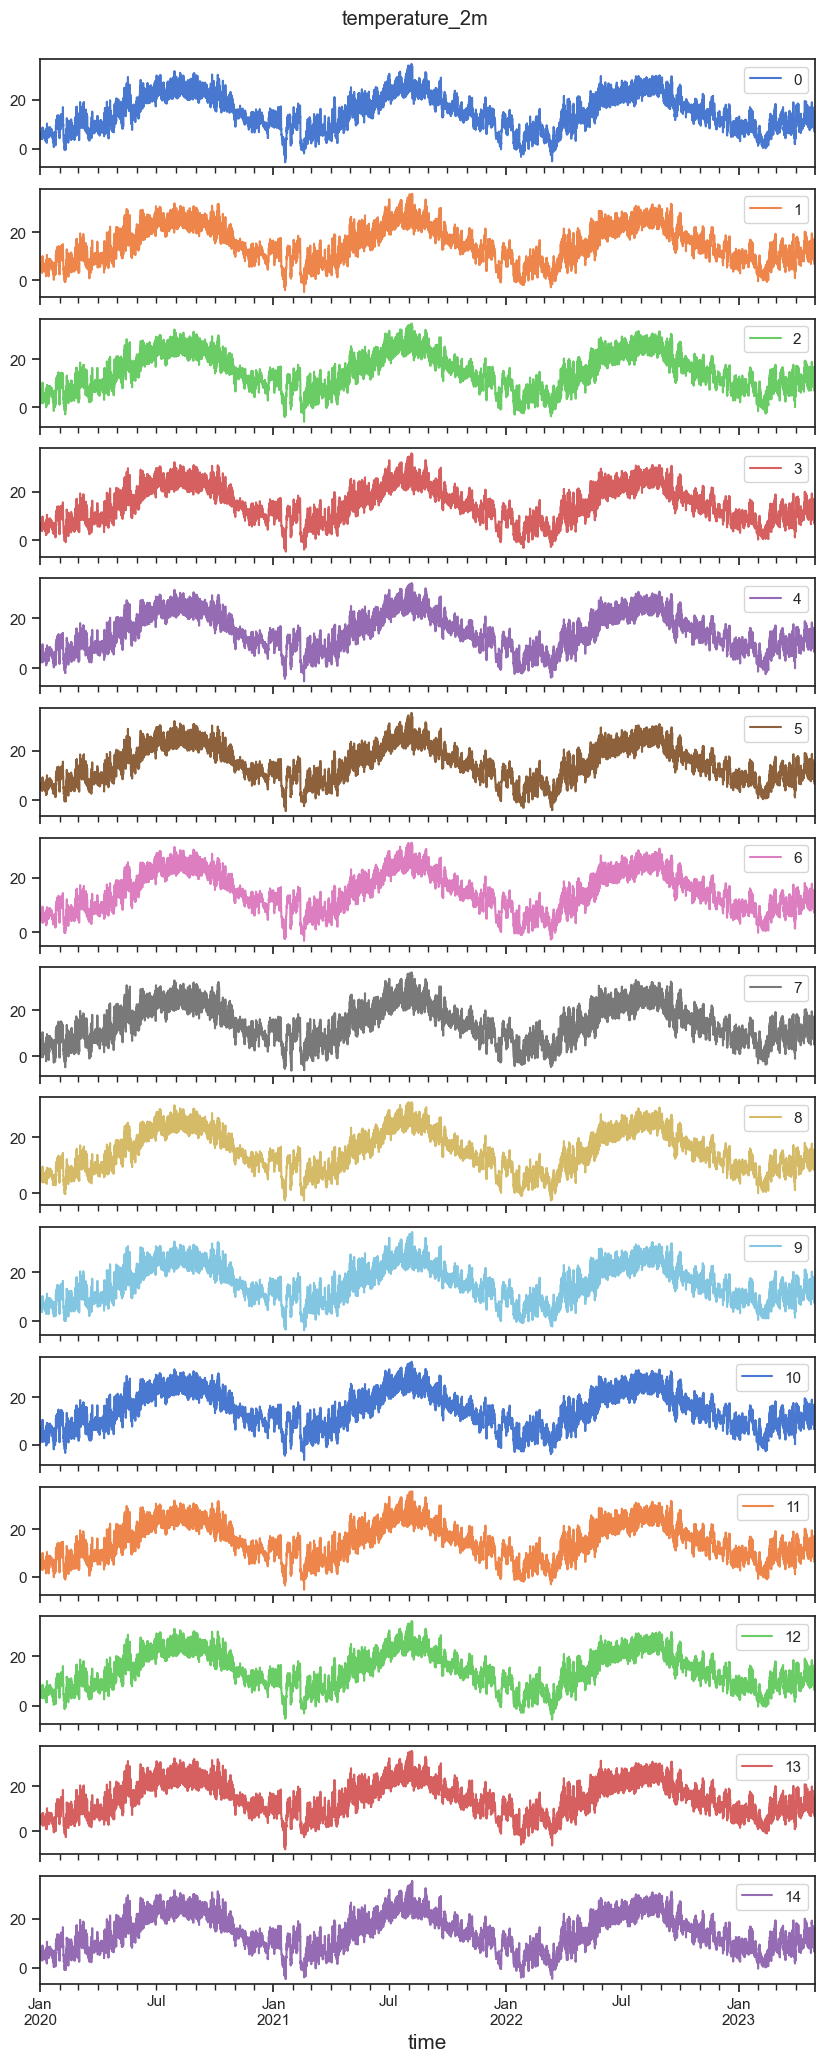

In [20]:
plot_wthr_ts('temperature_2m')

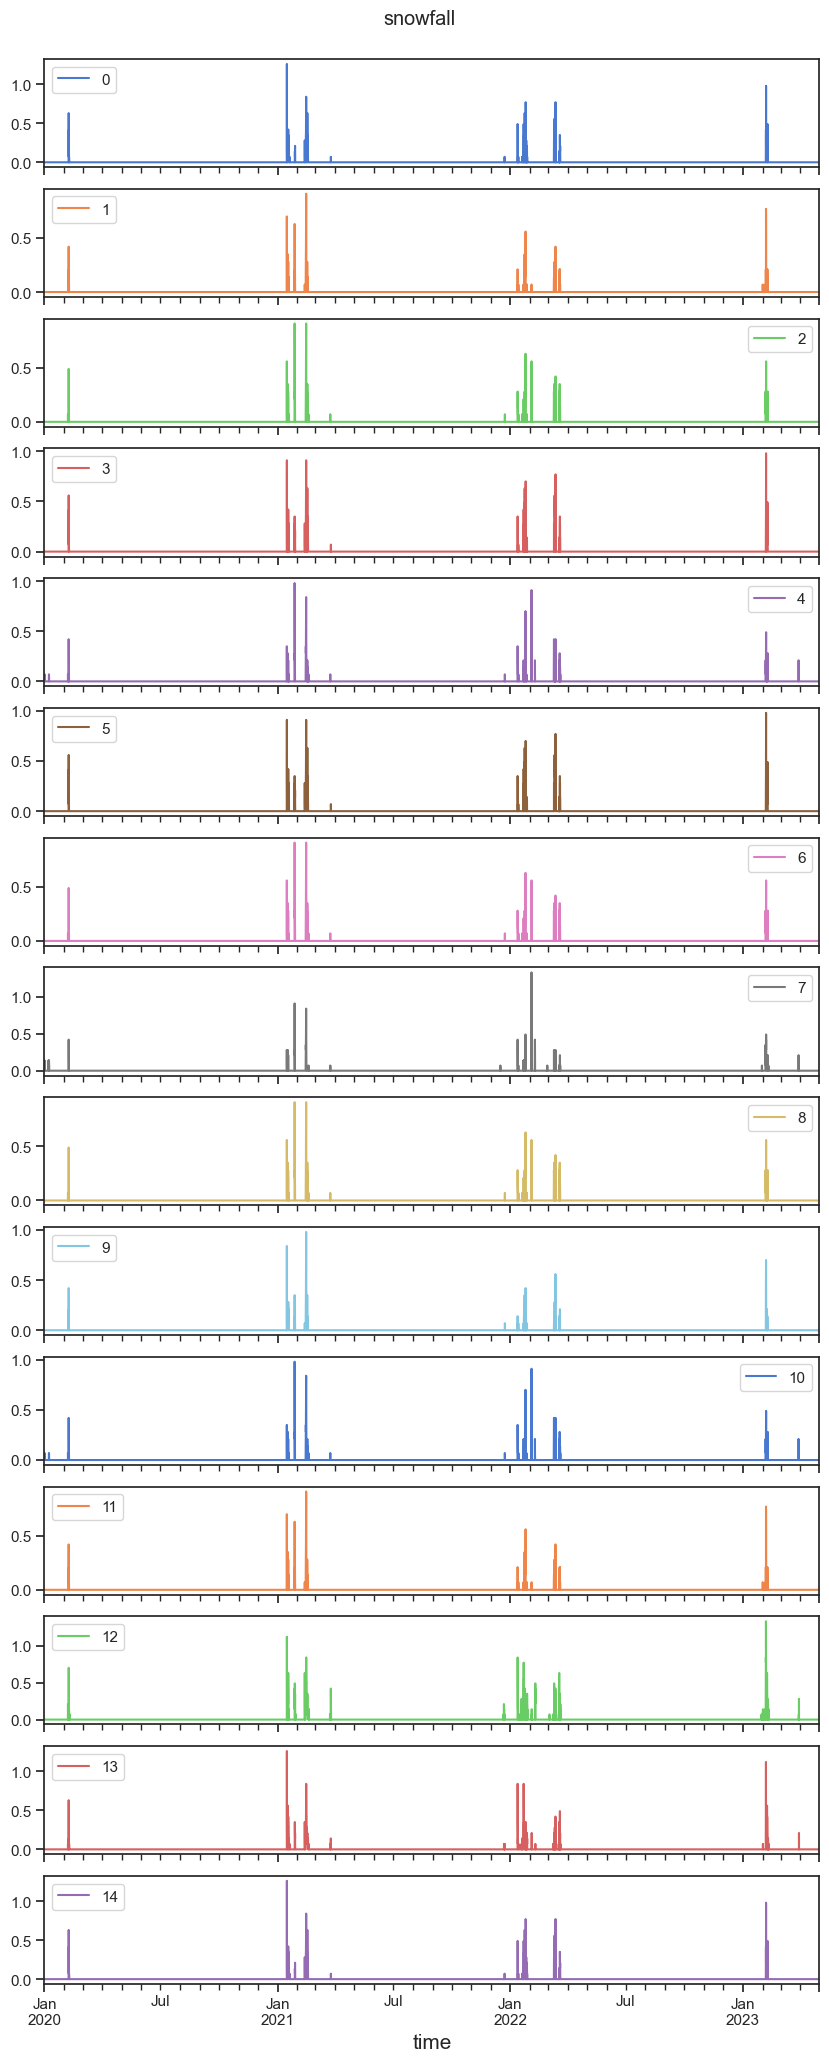

In [21]:
plot_wthr_ts('snowfall')

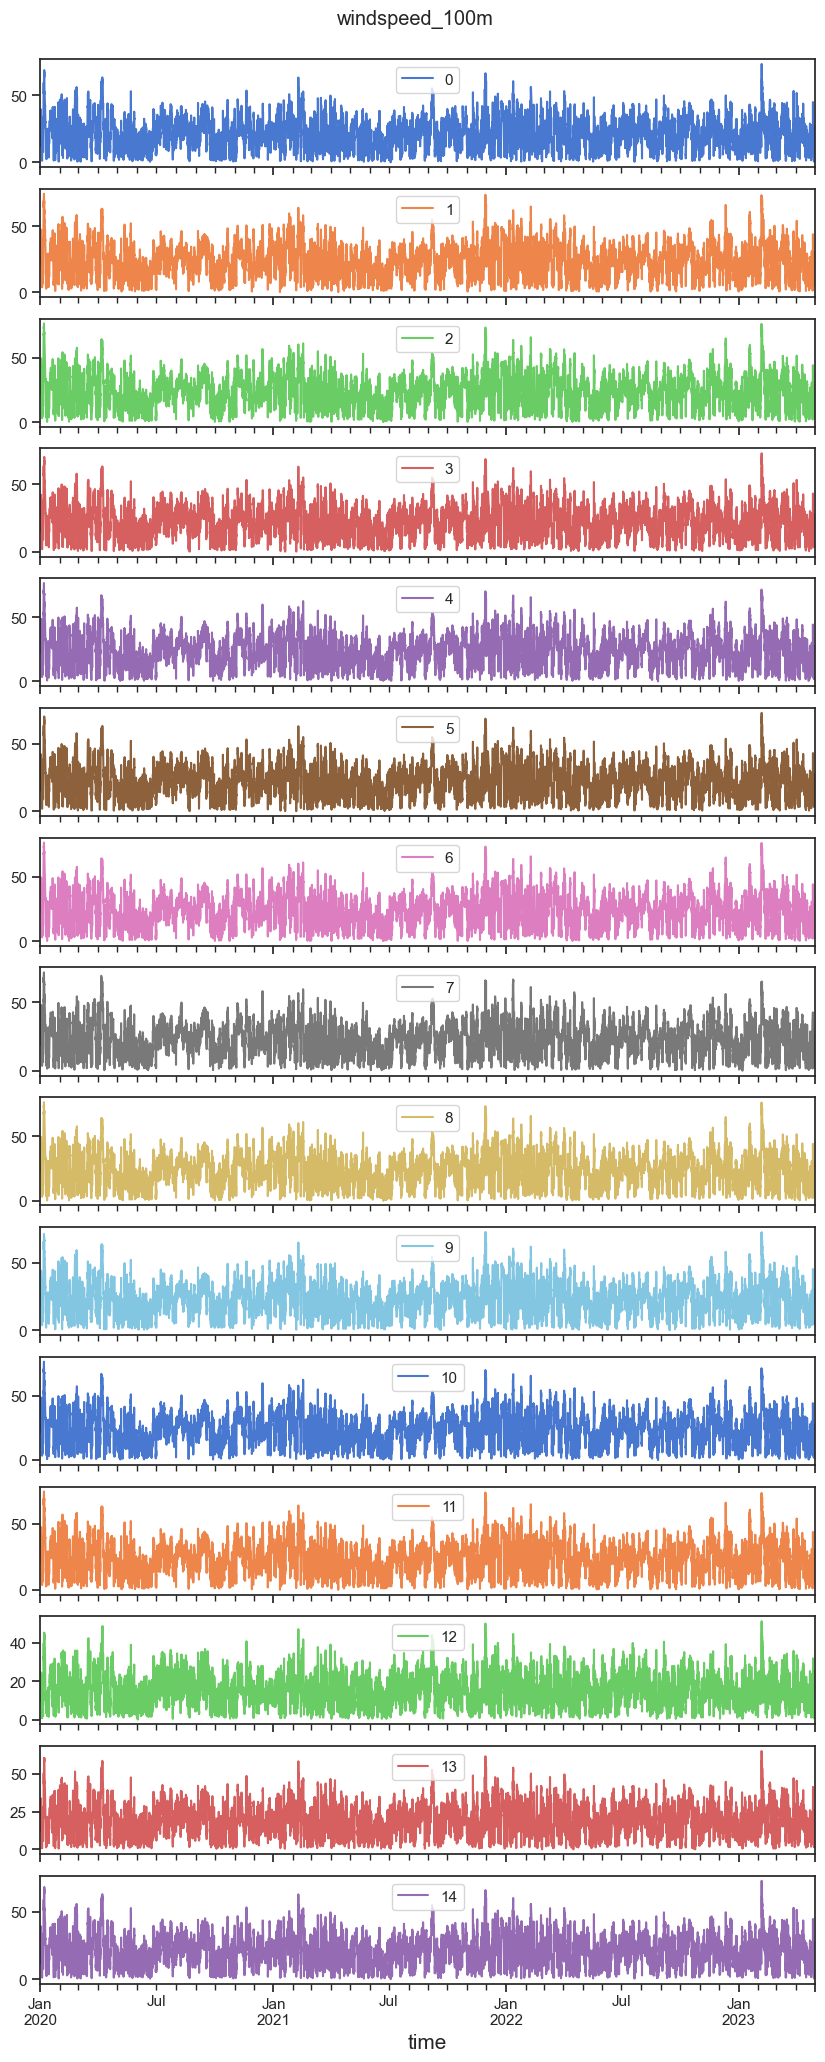

In [22]:
plot_wthr_ts('windspeed_100m')

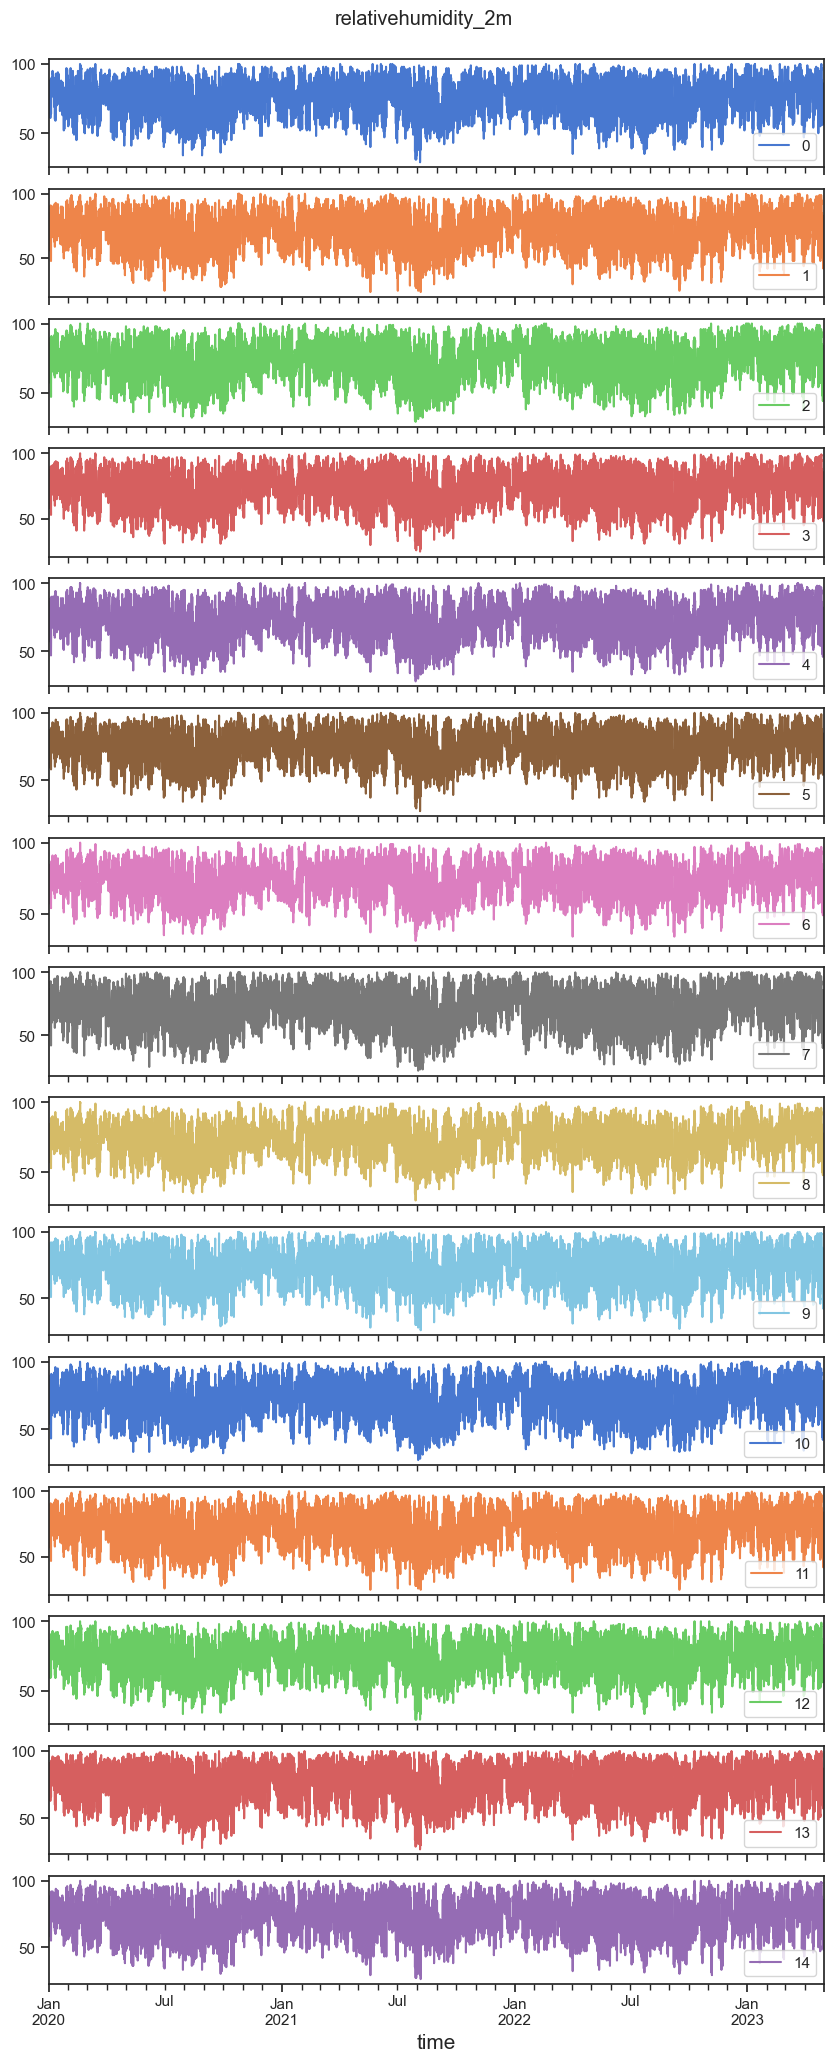

In [23]:
plot_wthr_ts('relativehumidity_2m')

In [24]:
(
    wthr_df
    .select('weathercode')
    .unique()
    .to_series()
    .sort()
)

weathercode
i64
0
1
2
3
51
53
55
61
63


In [25]:
wthr_df = (
    wthr_df
    .with_columns(pl.when(pl.col('weathercode').is_in([0, 1, 2, 3])).then('normal')
                  .when(pl.col('weathercode').eq(51)).then('light_drizzle')
                  .when(pl.col('weathercode').eq(53)).then('moderate_drizzle')
                  .when(pl.col('weathercode').eq(55)).then('heavy_drizzle')
                  .when(pl.col('weathercode').eq(61)).then('light_rain')
                  .when(pl.col('weathercode').eq(63)).then('moderate_rain')
                  .when(pl.col('weathercode').eq(71)).then('light_snow')
                  .when(pl.col('weathercode').eq(73)).then('moderate_snow')
                  .when(pl.col('weathercode').eq(75)).then('heavy_snow')
                  .alias('weather_category'))
    .drop('weathercode')
)

wthr_df.head()

time,temperature_2m,relativehumidity_2m,precipitation,rain,snowfall,windspeed_100m,CLUSTER,weather_category
str,f64,i64,f64,f64,f64,f64,i64,str
"""2020-01-01T00:…",6.1,84,0.0,0.0,0.0,15.6,0,"""normal"""
"""2020-01-01T01:…",6.3,82,0.0,0.0,0.0,17.4,0,"""normal"""
"""2020-01-01T02:…",6.4,81,0.0,0.0,0.0,20.3,0,"""normal"""
"""2020-01-01T03:…",6.3,80,0.0,0.0,0.0,21.2,0,"""normal"""
"""2020-01-01T04:…",6.2,79,0.0,0.0,0.0,21.6,0,"""normal"""


### **SOURCE: https://open-meteo.com/en/docs/historical-weather-api**

    * temperature_2m (°C): Air temperature at 2 meters above ground
    * precipitation (mm): Total precipitation (rain, showers, snow) sum of the preceding hour. Data is stored with a 0.1 mm precision.
    * rain	(mm): Only liquid precipitation of the preceding hour including local showers and rain from large scale systems.
    * snowfall (cm): Snowfall amount of the preceding hour in centimeters.
    * windspeed_10m (km/h):	Wind speed at 10 or 100 meters above ground. Wind speed on 10 meters is the standard level.

In [26]:
wthr_df_clean = (
    wthr_df
    .with_columns(pl.col('time').str.to_datetime(time_unit='ns'),
                  pl.exclude(['time', 'CLUSTER', 'relativehumidity_2m', 'weathercode', 'weather_category']).cast(pl.Float32),
                  pl.col(['CLUSTER', 'relativehumidity_2m']).cast(pl.UInt8),
                  pl.col(['weather_category']).cast(pl.Categorical))
    .rename({'time' : 'DATE_TIME', 
             'temperature_2m' : 'TEMP',
             'relativehumidity_2m' : 'HUMIDITY', 
             'precipitation' : 'PRCP',
             'rain' : 'RAIN',
             'snowfall' : 'SNOW',
             "windspeed_100m" : 'WINDSPEED',
             'weather_category' : 'WTHR_CAT'})
)

wthr_df_clean.head()

DATE_TIME,TEMP,HUMIDITY,PRCP,RAIN,SNOW,WINDSPEED,CLUSTER,WTHR_CAT
datetime[ns],f32,u8,f32,f32,f32,f32,u8,cat
2020-01-01 00:00:00,6.1,84,0.0,0.0,0.0,15.6,0,"""normal"""
2020-01-01 01:00:00,6.3,82,0.0,0.0,0.0,17.4,0,"""normal"""
2020-01-01 02:00:00,6.4,81,0.0,0.0,0.0,20.299999,0,"""normal"""
2020-01-01 03:00:00,6.3,80,0.0,0.0,0.0,21.200001,0,"""normal"""
2020-01-01 04:00:00,6.2,79,0.0,0.0,0.0,21.6,0,"""normal"""


In [27]:
wthr_clstr_gh = (
    wthr_df_clean
    .join((
            pl.read_csv("datasets/15_gh_info/geohash_traffic_density_pt_15clusters.csv", 
                        columns=['GEOHASH', 'label'])
            .with_columns(pl.col('label').cast(pl.UInt8),
                          pl.col('GEOHASH').cast(pl.Categorical))
            .rename({'label' : 'CLUSTER'})
        ), on='CLUSTER')
)

wthr_clstr_gh.head()

DATE_TIME,TEMP,HUMIDITY,PRCP,RAIN,SNOW,WINDSPEED,CLUSTER,WTHR_CAT,GEOHASH
datetime[ns],f32,u8,f32,f32,f32,f32,u8,cat,cat
2020-01-01 00:00:00,6.1,84,0.0,0.0,0.0,15.6,0,"""normal""","""sxkb9d"""
2020-01-01 00:00:00,6.1,84,0.0,0.0,0.0,15.6,0,"""normal""","""sxkbdq"""
2020-01-01 00:00:00,6.1,84,0.0,0.0,0.0,15.6,0,"""normal""","""sxkc68"""
2020-01-01 00:00:00,6.1,84,0.0,0.0,0.0,15.6,0,"""normal""","""sxkbu7"""
2020-01-01 00:00:00,6.1,84,0.0,0.0,0.0,15.6,0,"""normal""","""sxkb3x"""


### Istanbul Districts

In [28]:
# GEOHASH with District information
gh_dst = (
    pl.read_csv("datasets/15_gh_info/ist_geohash_district.csv")
    .with_columns(pl.all().cast(pl.Categorical))
)

gh_dst.head()

GEOHASH,DISTRICT
cat,cat
"""sxk3xw""","""Başakşehir"""
"""sxk9nm""","""Ataşehir"""
"""sxk9q0""","""Ataşehir"""
"""sxk3hx""","""Beylikdüzü"""
"""sx7cmx""","""Silivri"""


In [29]:
gh_dst['DISTRICT'].unique().sort().to_list()

['Başakşehir',
 'Ataşehir',
 'Beylikdüzü',
 'Silivri',
 'Sarıyer',
 'Bakırköy',
 'Eyüpsultan',
 'Büyükçekmece',
 'Esenyurt',
 'Kadıköy',
 'Üsküdar',
 'Sultangazi',
 'Küçükçekmece',
 'Pendik',
 'Arnavutköy',
 'Kartal',
 'Sancaktepe',
 'Ümraniye',
 'Bağcılar',
 'Kâğıthane',
 'Esenler',
 'Çekmeköy',
 'Güngören',
 'Darıca',
 'Maltepe',
 'Çatalca',
 'Avcılar',
 'Beykoz',
 'Çayırova',
 'Şişli',
 'Beyoğlu',
 'Tuzla',
 'Bayrampaşa',
 'Fatih',
 'Marmaraereğlisi',
 'Çerkezköy',
 'Beşiktaş',
 'Sultanbeyli',
 'Gebze',
 'Zeytinburnu',
 'Ergene',
 'Bahçelievler',
 'Gaziosmanpaşa',
 'Kapaklı',
 'Çorlu']

# Merging with tr_ist_td_merged_01_ver01.zstd

In [30]:
%%time

td_df = (
    # Reading Part 1 Merged file
    pl.scan_parquet("datasets/00_tr_df_merged/tr_ist_td_merged_01_ver01.zstd")
    
    # Football Matches
    .join(gh_football_match_info.lazy(), on=['GEOHASH', 'DATE_TIME'], how='left')
    .with_columns(pl.col('IS_FOOTBALL_MATCH').fill_null(0).cast(pl.Boolean))

    # Landmarks
    .join(gh_landmarks.lazy(), on='GEOHASH', how='left')
    .with_columns(pl.col('NEARBY_LANDMARKS_CNT').fill_null(0))

    # ISPARK parking spaces. GEOHASH with null capacity will be replaced with 0, 
    # indicating there are no available parking spaces nearby.
    .join(gh_ispark_capacity.lazy(), on='GEOHASH', how='left')
    .with_columns(pl.col('NEARBY_PARKING_CAPACITY').fill_null(0))

    # Taxi stands
    .join(gh_taxi_stands.lazy(), on='GEOHASH', how='left')
    .with_columns(pl.col('NEARBY_TAXI_STND_CNT').fill_null(0))

    # Minibus stops
    .join(gh_minibus_stops.lazy(), on='GEOHASH', how='left')
    .with_columns(pl.col('NEARBY_MINIBUS_STOPS_CNT').fill_null(0))

    # Ferries
    .join(gh_ferries.lazy(), on='GEOHASH', how='left')
    .with_columns(pl.col('NEARBY_FERRIES_CNT').fill_null(0))

    # Metro Stations
    .join(gh_metro_stn.lazy(), on='GEOHASH', how='left')
    .with_columns(pl.col('NEARBY_METRO_STNS_CNT').fill_null(0))

    # Bus Stops
    .join(gh_bus_stops.lazy(), on='GEOHASH', how='left')
    .with_columns(pl.col('NEARBY_BUS_STOP_CNT').fill_null(0))

    # Weather data
    .join(wthr_clstr_gh.lazy(), on=['GEOHASH', 'DATE_TIME'], how='left')

    # DISTRICTS
    .join(gh_dst.lazy(), on='GEOHASH', how='left')

).collect(streaming=True)


td_df.head()

Wall time: 2min 8s


DATE_TIME,LATITUDE,LONGITUDE,GEOHASH,AVERAGE_SPEED,NUMBER_OF_VEHICLES,CITIZEN_RETURN,CITIZEN_ARRIVAL,TOURIST_ARRIVAL,HOLIDAY_NAME,HOLIDAY_TYPE,SCHOOL_HOLIDAY_TYPE,HIGHWAY_TRNSPRT_PSNGRS,SEA_TRNSPRT_PSNGRS,RAIL_TRNSPRT_PSNGRS,IS_COVID_RESTRICTION,IS_FOOTBALL_MATCH,NEARBY_LANDMARKS_CNT,NEARBY_PARKING_CAPACITY,NEARBY_TAXI_STND_CNT,NEARBY_MINIBUS_STOPS_CNT,NEARBY_FERRIES_CNT,NEARBY_METRO_STNS_CNT,NEARBY_BUS_STOP_CNT,TEMP,HUMIDITY,PRCP,RAIN,SNOW,WINDSPEED,CLUSTER,WTHR_CAT,DISTRICT
datetime[ns],f32,f32,cat,u8,u16,u32,u32,u32,cat,cat,cat,u32,u32,u32,bool,bool,u8,u16,u8,u8,u8,u8,u8,f32,u8,f32,f32,f32,f32,u8,cat,cat
2020-01-01 00:00:00,40.78949,29.415894,"""sxkbj3""",72,97,627933,692729,1017034,"""New Year's Day…","""National holid…","""Christmas holi…",15430,2211,31247,false,false,0,0,0,0,0,0,1,5.8,88,0.0,0.0,0.0,14.9,13,"""normal""","""Gebze"""
2020-01-01 01:00:00,40.78949,29.415894,"""sxkbj3""",74,58,627933,692729,1017034,"""New Year's Day…","""National holid…","""Christmas holi…",12108,1464,27136,false,false,0,0,0,0,0,0,1,6.0,87,0.0,0.0,0.0,16.1,13,"""normal""","""Gebze"""
2020-01-01 02:00:00,40.78949,29.415894,"""sxkbj3""",79,40,627933,692729,1017034,"""New Year's Day…","""National holid…","""Christmas holi…",9168,815,13970,false,false,0,0,0,0,0,0,1,6.1,86,0.0,0.0,0.0,18.6,13,"""normal""","""Gebze"""
2020-01-01 03:00:00,40.78949,29.415894,"""sxkbj3""",74,33,627933,692729,1017034,"""New Year's Day…","""National holid…","""Christmas holi…",6585,517,8190,false,false,0,0,0,0,0,0,1,6.0,85,0.0,0.0,0.0,19.799999,13,"""normal""","""Gebze"""
2020-01-01 04:00:00,40.78949,29.415894,"""sxkbj3""",79,25,627933,692729,1017034,"""New Year's Day…","""National holid…","""Christmas holi…",5054,219,5310,false,false,0,0,0,0,0,0,1,5.9,85,0.0,0.0,0.0,20.5,13,"""normal""","""Gebze"""


In [31]:
# Merged dataset information
print(f'Estimated Size of merged df: {td_df.estimated_size("gb"):.3f} GB')
print(f'Dataset Shape: {td_df.shape[0]:,} rows, {td_df.shape[1]} columns')

Estimated Size of merged df: 4.792 GB
Dataset Shape: 52,910,592 rows, 33 columns


In [32]:
# Null counts by column
(
    td_df
    .null_count()
    .to_pandas().T
    .rename(columns={0 : "null_counts"})
)

,null_counts
DATE_TIME,0
LATITUDE,0
LONGITUDE,0
GEOHASH,0
AVERAGE_SPEED,0
NUMBER_OF_VEHICLES,0
CITIZEN_RETURN,0
CITIZEN_ARRIVAL,0
TOURIST_ARRIVAL,0
HOLIDAY_NAME,0


In [33]:
# Saving Merged file to parquet
td_df.write_parquet("datasets/00_tr_df_merged/tr_ist_td_merged_full.zstd", compression="zstd")